In [64]:
%matplotlib inline
from math import pi
import openmc
import openmc.deplete
import matplotlib.pyplot as plt

Let's use the same material definition as the existing pincell depletion example 

In [78]:
# Instantiate some Materials and register the appropriate Nuclides
uo2 = openmc.Material(name='UO2 fuel at 2.4% wt enrichment')
uo2.set_density('g/cm3', 10.29769)
uo2.add_element('U', 1., enrichment=2.4)
uo2.add_element('O', 2.)

helium = openmc.Material(name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 2.4044e-4)

zircaloy = openmc.Material(name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014, 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001, 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')

borated_water = openmc.Material(name='Borated water')
borated_water.set_density('g/cm3', 0.740582)
borated_water.add_element('B', 4.0e-5)
borated_water.add_element('H', 5.0e-2)
borated_water.add_element('O', 2.4e-2)
borated_water.add_s_alpha_beta('c_H_in_H2O')

# Define overall material
material = openmc.Materials([uo2, helium, zircaloy, borated_water])

The geometry definition is going to be slightly different. Firstly, we want to bound the geometry in z assigning a pincell height. Secondly, we want to define a cell that contains a universe made of water and helium cells, separated by an interface, which we can initially set at -59 cm so that the $k_{eff} \sim 1$. 

Filling the "msr" cell with a universe is the requirement to use the msr batchwise geometrical scheme as we will see later on.    

In [91]:
# Define surfaces
width = 1.25984
height = 200
fuel_or = openmc.ZCylinder(r=0.39218, name='Fuel OR')
clad_ir = openmc.ZCylinder(r=0.40005, name='Clad IR')
clad_or = openmc.ZCylinder(r=0.45720, name='Clad OR')
wat_or = openmc.ZCylinder(r=width/2, name='H2O OR', boundary_type='reflective')
interface = openmc.ZPlane(z0=-59, name='IF')
z_top = openmc.ZPlane(z0=height/2, name='Pin TOP', boundary_type='vacuum')
z_bot = openmc.ZPlane(z0=-height/2, name='Pin BOT', boundary_type='vacuum')

# Define cells
fuel = openmc.Cell(fill=uo2, region=-fuel_or & -z_top & +z_bot)
gap = openmc.Cell(fill=helium, region=+fuel_or & -clad_ir & -z_top & +z_bot)
clad = openmc.Cell(fill=zircaloy, region=+clad_ir & -clad_or & -z_top & +z_bot)
water = openmc.Cell(fill=borated_water, region=+clad_or & -interface )
gas = openmc.Cell(fill=helium, region=+clad_or & +interface)
msr_uni = openmc.Universe(cells=(water, gas))
msr = openmc.Cell(name="MSR", fill=msr_uni, region=-wat_or & -z_top & +z_bot)
# Define overall geometry
geometry = openmc.Geometry([fuel, gap, clad, msr])

In [80]:
# Set material volume for depletion.
uo2.volume = pi * fuel_or.r**2 * height

In [87]:
# Instantiate a Settings object, set all runtime parameters, and export to XML
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.62992, -0.62992, -100, 0.62992, 0.62992, 100]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings.source = openmc.source.Source(space=uniform_dist)

#Build the model
model = openmc.Model(geometry=geometry, materials=material, settings=settings)

Let's plot the pincell. We can notice the initial interface between the borated water and helium cells.

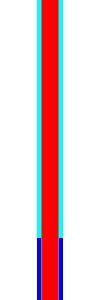

In [90]:
# Create plot
geometry.export_to_xml()
material.export_to_xml()
plot = openmc.Plot.from_geometry(geometry)
plot.basis = 'xz'
plot.width = (5,200)
plot.pixels = (100,300)
plot.color_by = 'material'
plot.colors = {uo2:'red', helium:'cyan', borated_water: 'blue', zircaloy: 'gray'}
openmc.plot_inline(plot)

Let's now build and run a standard depletion calculation, increasing the thermal power to 100 kW. The results will be used as the reference to compare with the MSR capabilities:

In [99]:
#Create depletion "operator"
chain_file = 'chain_simple.xml'
op = openmc.deplete.CoupledOperator(model, chain_file)
# Perform simulation using the predictor algorithm
time_steps = [1.0, 1.0, 1.0, 1.0, 1.0]  # days
power = 100000  # W
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, timestep_units='d')
integrator.integrate()

[openmc.deplete] t=0.0 s, dt=86400.0 s, source=100000
Timestep: 0 --> keff: 1.00098
[openmc.deplete] t=86400.0 s, dt=86400.0 s, source=100000
Timestep: 1 --> keff: 0.98427
[openmc.deplete] t=172800.0 s, dt=86400.0 s, source=100000
Timestep: 2 --> keff: 0.98158
[openmc.deplete] t=259200.0 s, dt=86400.0 s, source=100000
Timestep: 3 --> keff: 0.98486
[openmc.deplete] t=345600.0 s, dt=86400.0 s, source=100000
Timestep: 4 --> keff: 0.98133
[openmc.deplete] t=432000.0 (final operator evaluation)


We can now analazie the depletion results

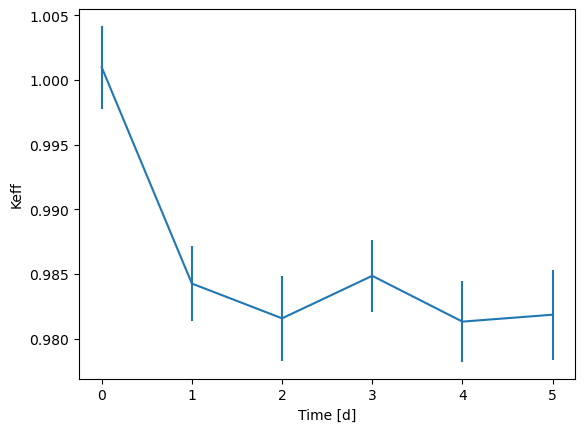

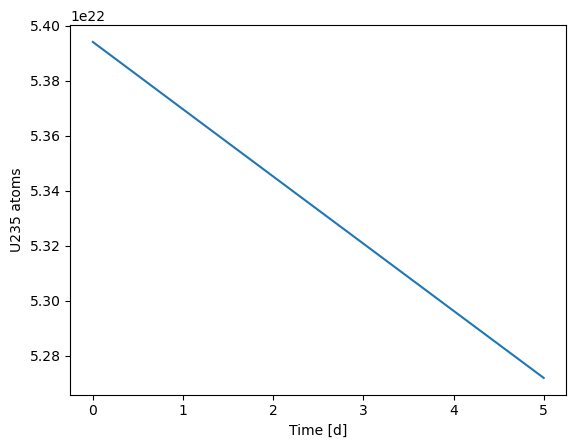

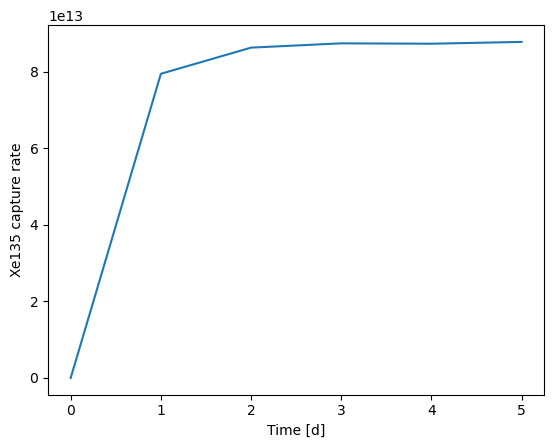

In [102]:
# Open results file
results = openmc.deplete.Results("depletion_results.h5")

# Obtain K_eff as a function of time
time, keff = results.get_keff(time_units='d')

# Obtain U235 concentration as a function of time
_, n_U235 = results.get_atoms(uo2, 'U235')

# Obtain Xe135 capture reaction rate as a function of time
_, Xe_capture = results.get_reaction_rate(uo2, 'Xe135', '(n,gamma)')

# Generate plots
fig, ax = plt.subplots()
ax.errorbar(time, keff[:, 0], keff[:, 1], label="K-effective")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Keff")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, n_U235, label="U235")
ax.set_xlabel("Time [d]")
ax.set_ylabel("U235 atoms")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, Xe_capture, label="Xe135 capture")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Xe135 capture rate")
plt.show()

Let's now introduce the concept of `continuous removal rate` at which some nuclides/elements get removed from the materials, as an additional proportional term to the Bateman equations. This concept assumes first-order removal and homegeneous distributions of the fission products (or elements to removed) throughout the material.

$ \frac{dn_i(t)}{dt} = \underbrace{\sum_j \gamma_{j\rightarrow i} n_j\overline{\sigma_j\phi} - n_i \overline{\sigma_i \phi}}_\textbf{R}  + \underbrace{\sum_j \gamma_{j\rightarrow i} n_j\lambda_{i\rightarrow j} + \lambda_{j\rightarrow i}n_i}_\textbf{D} - \underbrace{\epsilon_i \lambda_i n_i}_\textbf{T}$

Where $ \epsilon_i \lambda_i n_i $ is the removal term, and:

- $\epsilon_i$ is the removal efficiency 

- $\lambda_i$ is the removal rate coefficient for the continuous removal of the nuclide $i$ in ($s^{-1}$)

Another way to characterize $\lambda_i$ is through the concept of cycle time:

$T_{cyc,i} = \frac{1}{\lambda_i}$, as the time needed to process the removal elements at a specific volumetric rate. 

Thus, a new depletion matrix can be built as: 

$\frac{d\vec{n}}{dt} = \underbrace{(\textbf{R+D-T})}_\textbf{A}\vec{n} $, where
- $\textbf{R}$ is the reaction rate term
- $\textbf{D}$ is the decay rate term 
- $\textbf{T}$ is the removal rate or transfer term 

That can be solved in a similar fashion. 

Back to our case, for sake of example, let's set a removal rate of $0.1 (s^{-1})$ for `Xenon` and re-run the the depletion model. 
To do it, we need to instantiate a `openmc.deplete.msr.MsrContinuous` object first, and use the `set_removal_rate` function to set a removal rate to a list of elements (only Xe in this case) and the depletable material to remove from. Lastly, we need to pass our instance to the integrator object.    

In [103]:
# Re-create the depletion "operator"
op = openmc.deplete.CoupledOperator(model, chain_file)
#Create msr continuous instance
msr_c = openmc.deplete.msr.MsrContinuous(op, model)
# Set removal rate from UO2 for Xe. Default units is [sec-1]
msr_c.set_removal_rate('UO2 fuel at 2.4% wt enrichment', ['Xe'], 0.1)
# Pass the msr instance to the integrator object
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, msr_continuous=msr_c,  timestep_units='d')
integrator.integrate()

[openmc.deplete] t=0.0 s, dt=86400.0 s, source=100000
Timestep: 0 --> keff: 1.00098
[openmc.deplete] t=86400.0 s, dt=86400.0 s, source=100000
Timestep: 1 --> keff: 1.00231
[openmc.deplete] t=172800.0 s, dt=86400.0 s, source=100000
Timestep: 2 --> keff: 0.99987
[openmc.deplete] t=259200.0 s, dt=86400.0 s, source=100000
Timestep: 3 --> keff: 0.99911
[openmc.deplete] t=345600.0 s, dt=86400.0 s, source=100000
Timestep: 4 --> keff: 1.00129
[openmc.deplete] t=432000.0 (final operator evaluation)


Let's open the results and plot them again:

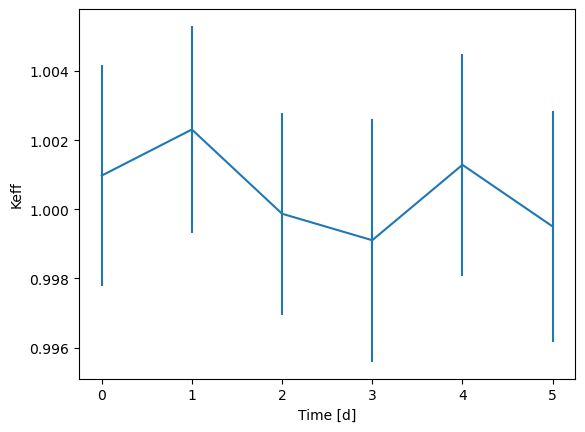

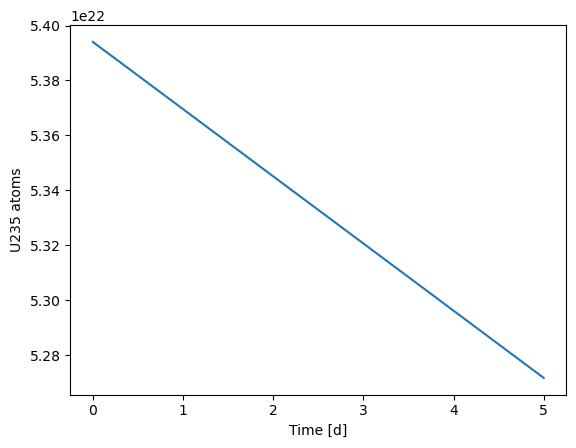

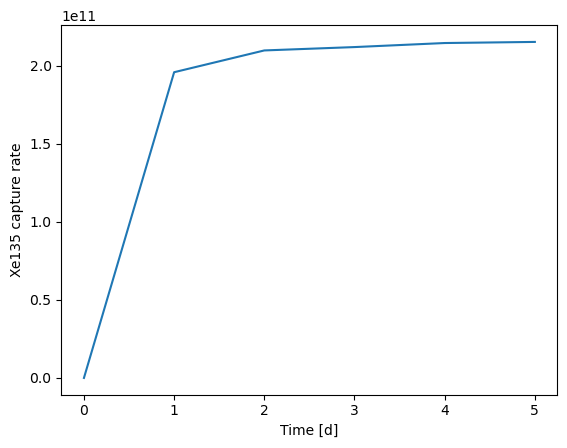

In [104]:
results = openmc.deplete.Results("depletion_results.h5")
time, keff = results.get_keff(time_units='d')
_, n_U235 = results.get_atoms(uo2, 'U235')
_, Xe_capture = results.get_reaction_rate(uo2, 'Xe135', '(n,gamma)')

fig, ax = plt.subplots()
ax.errorbar(time, keff[:, 0], keff[:, 1], label="K-effective")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Keff")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, n_U235, label="U235")
ax.set_xlabel("Time [d]")
ax.set_ylabel("U235 atoms")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, Xe_capture, label="Xe135 capture")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Xe135 capture rate")
plt.show()

As we can, `Xe135` capture rate has reduced indicating that the removal has worked, and consequently `keff` is kept almost constantly. 

Let's now show the capability of the `batchwise`control instead. We want to apply single actions in time to the system to fulfill some objectives, such as maintain a certain level of criticality. The current MSR implementation allows the user to define `geometry-based`or `material-based`actions. 

Back to our example, let's assume we want to maintain $k_{eff}$ close to its initial value $(\sim 1.00 )$ during the whole depletion time, by dynamically increasing the quantity of borated water that acts as moderator and compensate for the neutrons capture of the fission products build-up. The `msr` cell that was previously defined and filled with an universe containing borated water and helium gas, can translate up and down, increasing and decreasing the borated water cell volume, respectively. The `geometry-based` algorithm will run a `search_for_keff` at every depletion time-step to find the new interface coefficient that fulfills the target condition.  

Here we only need to instantiate  `openmc.deplete.msr.MsrBatchwiseGeom` object and set it up with the relevant arguments:
- axis=2 : we want the cell translation on the z-axis
- bracket=[-2,2]: we want to limit the `search_for_keff` to $\pm2$ cm from the initial or previous iteration geometrical value. 
- bracket_limit=[-100,100] : this sets the limit of the `search_for_keff` to our pincell height 
- tol=0.01 : `search_for_keff` tolerance 
- target=1.145 : `search_for_keff` target 


In [105]:
# Re-create the depletion "operator"
op = openmc.deplete.CoupledOperator(model, chain_file)
#Create msr batchwise geometrical instance
msr_g = openmc.deplete.msr.MsrBatchwiseGeom(op, model, cell_id_or_name = 'MSR',
                axis=2, bracket=[-2,2], bracket_limit=[-100,100], tol=0.01, target=1.00)
# Pass the msr instance to the integrator object
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, msr_batchwise=msr_g,  timestep_units='d')
integrator.integrate()

[openmc.deplete] t=0.0 s, dt=86400.0 s, source=100000
Timestep: 0 --> keff: 1.00098
[openmc.deplete] t=86400.0 s, dt=86400.0 s, source=100000
Iteration: 1; Guess of -2.00e+00 produced a keff of 0.97332 +/- 0.00314
Iteration: 2; Guess of 2.00e+00 produced a keff of 0.99716 +/- 0.00305
INFO: Function returned values below or above target. Adapt bracket...
1
Iteration: 1; Guess of 2.00e+00 produced a keff of 0.99953 +/- 0.00310
Iteration: 2; Guess of 2.48e+00 produced a keff of 0.99763 +/- 0.00271
INFO: Function returned values below or above target. Adapt bracket...
-1
Iteration: 1; Guess of 1.88e+00 produced a keff of 0.99405 +/- 0.00295
Iteration: 2; Guess of 2.00e+00 produced a keff of 1.00325 +/- 0.00304
Iteration: 3; Guess of 1.96e+00 produced a keff of 1.00415 +/- 0.00252
Iteration: 4; Guess of 1.92e+00 produced a keff of 0.99314 +/- 0.00287
Iteration: 5; Guess of 1.94e+00 produced a keff of 0.99270 +/- 0.00337
UPDATE: old value: 0.00 cm --> new value: 1.96 cm
1.9586864037484442
Ti

By looking at the output, we notice that when the `search_for_keff` bracket goes off target, the method iteratively adapts it. 

Again, let's analyse the results:

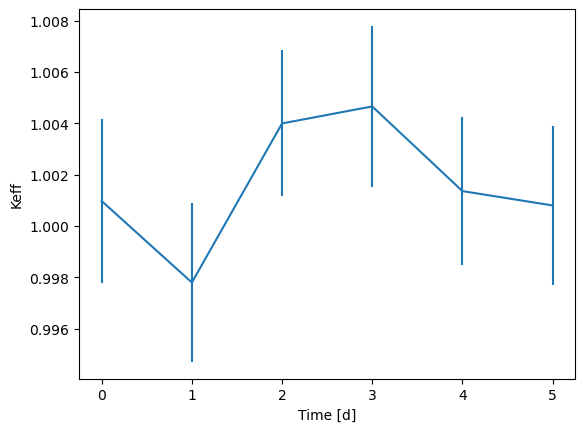

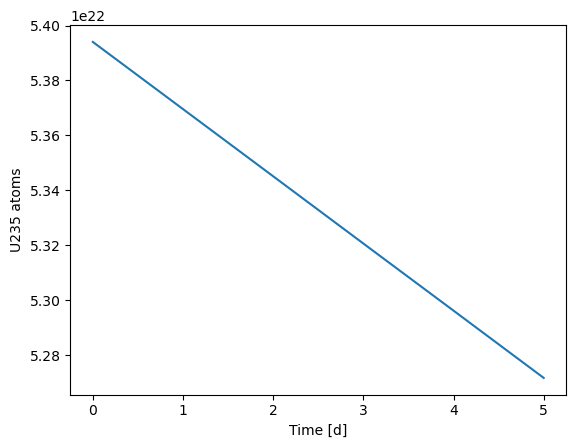

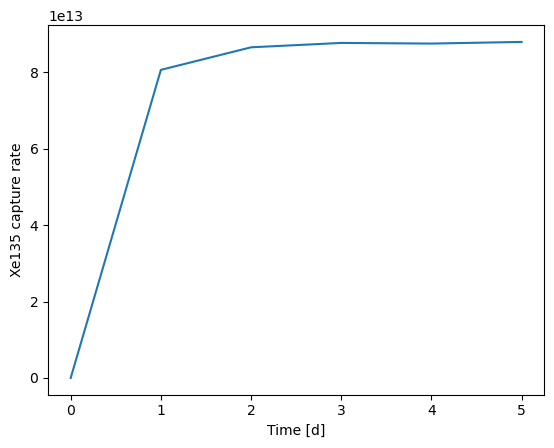

In [106]:
results = openmc.deplete.Results("depletion_results.h5")
time, keff = results.get_keff(time_units='d')
_, n_U235 = results.get_atoms(uo2, 'U235')
_, Xe_capture = results.get_reaction_rate(uo2, 'Xe135', '(n,gamma)')

fig, ax = plt.subplots()
ax.errorbar(time, keff[:, 0], keff[:, 1], label="K-effective")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Keff")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, n_U235, label="U235")
ax.set_xlabel("Time [d]")
ax.set_ylabel("U235 atoms")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, Xe_capture, label="Xe135 capture")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Xe135 capture rate")
plt.show()

As we can notice, $k_{eff} \sim 1$ even though `Xe135`(main absorber) hasn't been removed. This is achieved through water level raising only, as we can see by plotting the results stored in `msr_results.h5`

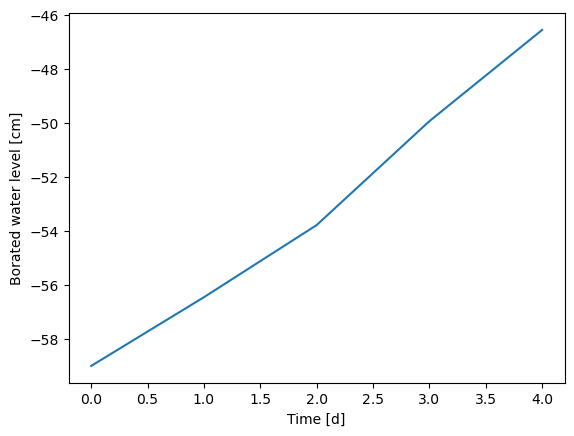

In [126]:
# To open the h5 file we need some imports
import h5py
import numpy as np
h = h5py.File('msr_results.h5','r')
vals = [] 
for key in h.keys():
    vals.append(np.array(h.get(key)))
fig, ax = plt.subplots()
# Offset the values by 59cm, our initial water level height
vals = np.cumsum(vals) - 59
ax.plot(time[:-1], vals)
ax.set_xlabel("Time [d]")
ax.set_ylabel("Borated water level [cm]")
plt.show()